In [49]:
from wrappedCode.createModel import *
from wrappedCode.encryptionWrapped import *
from wrappedCode.decryptionWrapped import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Model selection

As different models were used for the example, these models need to be chosen as part of the model selection. For GPT2 models, it can be chosen between:


*   "gpt2-small"
*   "gpt2-medium"
*   "gpt2-large"
*   "gpt2-xl"

Additionally, BERT and RoBERTa can also be selected.  




In [2]:
mod, tok= buildModel("gpt2") # make nice wrapper for this!

## Encryption of the secret text

Depending on the choice, the encryption can be conducted with complete sentences or incomplete sentences. For this example, the start of Adele's "Hello" is encrypted. 
As part of the encryption it can be decided, whether the last sentence should be completed. 



In [40]:
startOfText="This year's Shakespeare Festival"
precondSec=". "
secret = "EPFL is Europe’s most cosmopolitan technical university. It welcomes students, professors and collaborators of more than 120 nationalities."

secret = "EPFL is Europe’s most cosmopolitan technical university. It welcomes students, professors and collaborators of more than 120 nationalities. EPFL has both a Swiss and international vocation and focuses on three missions: teaching, research and innovation. EPFL collaborates with an important network of partners, including other universities and colleges, secondary schools and gymnasiums, industry and the economy, political circles and the general public, with the aim of having a real impact on society."

sentenceComplete=True

In [41]:
outText, outInd=encryptMessage(mod, tok, secret, precondSec, startOfText, False)

In [42]:
print("Cover text : {}".format(outText))

Cover text : This year's Shakespeare Festival Melt Off will champion t. The first contest will car-free, to celebrate "Sesame Family Tunes," from March 11-May 1, 2005. Melt Off has results from over a dozen festival prizes, so check out the contest page at the NOLA Center Facebook wall. Tickets are $27.
—
End of the exhibit
—
This Friday, December May 4 8A: The National Shakespeare Company is pleased to announce M. LaBrie, the


## Decryption of the cover text

For the decryption, the receiver needs to know the preconditioning of the secret and the start of the text. Given this and knowing, whether sentence completion was activated, the text can be recovered correctly. 



In [43]:
text = decryptMessage(mod, tok, outText, precondSec, startOfText, False)

In [44]:
print("Decrypted text : {}".format(text))

Decrypted text : . EPFL is Europe’s most cosmopolitan technical university. It welcomes students, professors and collaborators of more than 120 nationalities. EPFL has both a Swiss and international vocation and focuses on three missions: teaching, research and innovation. EPFL collaborates with an important network of partners, including other universities and colleges, secondary schools and gymnasiums, industry and the economy, political circles and the general public, with the aim of having a real impact on society.


## Evaluation 

### Smoothness of the generated text

In [8]:
GPT2_ = True
BERT_ = False

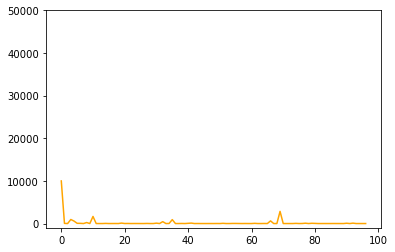

In [45]:
def plot_ranks_bert(mod, tok, precondSec, secret):
  ranks = []
  x = range(len(tok.encode(secret, add_special_tokens=False)))
  ranks = getRanks_BERT(mod, tok, precondSec, secret)
  plt.plot(x, ranks, color='orange')
  plt.ylim(-1000, 50000)
  plt.show()


def plot_ranks_gpt2(model_gpt, tok_gpt, precondSec, secret):
  x = range(len(tok_gpt.encode(secret)))
  ranks=getRanks_GPT(model_gpt, tok_gpt, secret, precondSec, False)
  plt.plot(x, ranks, color='orange')
  plt.ylim(-1000, 50000)
  plt.show()

if GPT2_:
  plot_ranks_gpt2(mod, tok, precondSec, secret)
elif BERT_:  
  plot_ranks_bert(mod, tok, precondSec, secret)

### Perplexity score

In [51]:
def get_perplex_score(cover_text, model, tokenizer, startingSecret=". "):
    probas = []
    token_secret = tokenizer.encode(cover_text)
    token_start = tokenizer.encode(startingSecret)
    # Convert indexed tokens in a PyTorch tensor
    tokens_tensor = torch.tensor([token_start])
    m = nn.Softmax(dim=0)
  # If you have a GPU, put everything on cuda
    tokens_tensor = tokens_tensor.to('cuda')
    model.to('cuda')
    pred = []
    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]
        tab = m(predictions[:, -1, :][0])
        pred.append(tab[token_secret[0]].item())
        for i in range(1, len(token_secret)):
            tokens_tensor = torch.cat((tokens_tensor.to('cpu').view(-1), torch.Tensor([token_secret[i]])), dim=-1).view(1, -1)
            outputs = model(tokens_tensor.type(torch.long).to("cuda"))
            predictions = outputs[0]
            tab = m(predictions[:, -1, :][0])
            pred.append(tab[token_secret[i]].item())
            
    s = 0
    for p in pred:
        s += np.log2(p)
    score = 2**((-1/len(pred))*s)
    return score

score = get_perplex_score(outText, mod, tok, ". ")
print("Perplexity score :{}".format(score))

Perplexity score :12521.961920388352
